### Install dependencies

In [413]:
# Install required libs

### PAPERSPACE ONLY ###
#!apt-get update && ln -snf /usr/share/zoneinfo/Europe/Berlin /etc/localtime && DEBIAN_FRONTEND=noninteractive apt-get install -y tzdata
#!apt-get install ffmpeg libsm6 libxext6 -y 
### PAPERSPACE ONLY END ###

#!python -m pip install --user tensorboard numpy matplotlib ipython ipykernel jupyter segmentation-models-pytorch albumentations opencv-python tqdm natsort scikit-image ipywidgets

In [414]:
from torchvision.datasets import VOCSegmentation
import os
import numbers
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch as smp
from natsort import natsorted
from functools import reduce
from skimage import io
import albumentations as albu
import numpy as np
from tqdm import tqdm
from timeit import default_timer as timer

In [415]:
# writer = SummaryWriter()
# log_dir_name = writer.get_logdir()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 8 if torch.cuda.is_available() else 0
print("Using {} device".format(DEVICE))
print("Using {} workers".format(NUM_WORKERS))

Using cpu device
Using 0 workers


### MHP dataset link

In [416]:
# Download LV-MHP-v2 manually and extract to data dir
# https://drive.google.com/file/d/1YVBGMru0dlwB8zu1OoErOazZoc8ISSJn/

# Voc will be downloaded later

# Helper functions

In [417]:
def verify_image(img_file):
    try:
        img = io.imread(img_file)
    except:
        return False
    return True

def get_mask_fp_infos(mask_fp):
    id, num_persons, curr_person = os.path.basename(mask_fp).split(".")[0].split("_")
    return int(id), int(num_persons), int(curr_person)

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


# Dataloaders


MHP

In [418]:
class Dataset(BaseDataset):
    """MHP v2 Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    CLASS_LABELS = [
        "Background", "Cap/hat","Helmet", "Face", "Hair", "Left-arm", "Right-arm", "Left-hand", "Right-hand", "Protector", 
        "Bikini/bra", "Jacket/windbreaker/hoodie", "Tee-shirt", "Polo-shirt", "Sweater", "Singlet", "Torso-skin", 
        "Pants", "Shorts/swim-shorts", "Skirt", "Stockings", "Socks", "Left-boot", "Right-boot", "Left-shoe",
        "Right-shoe", "Left-highheel", "Right-highheel", "Left-sandal", "Right-sandal", "Left-leg", "Right-leg",
        "Left-foot", "Right-foot", "Coat", "Dress", "Robe", "Jumpsuit" , "Other-full-body-clothes" , "Headwear",
        "Backpack", "Ball", "Bats", "Belt", "Bottle", "Carrybag", "Cases", "Sunglasses", "Eyewear", "Glove",
        "Scarf", "Umbrella"," Wallet/purse", "Watch", "Wristband", "Tie"," Other-accessary", 
        "Other-upper-body-clothes", "Other-lower-body-clothes"
        ]

    def __init__(self, size, classes=None, augmentation=None, preprocessing=None):
        images_dir = "data/LV-MHP-v2/train/images/"
        masks_dir = "data/LV-MHP-v2/train/parsing_annos/"
        self.images_ids = natsorted(os.listdir(images_dir))[0:size]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.images_ids]
        self.masks_ids = natsorted(os.listdir(masks_dir))
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.masks_ids]
    
        # convert str names to class values on masks
        self.class_indices = [self.CLASS_LABELS.index(cls) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        if verify_image(self.images_fps[i]):
            # read image
            image = cv2.imread(self.images_fps[i])
        else:
            image = cv2.imread(self.images_fps[i-1])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # combine mask files
        mask_files_per_image = []
        for el in self.masks_fps:
            mask_id = int(get_mask_fp_infos(el)[0]) 
            img_id = int(self.images_ids[i].split(".")[0])
            if(mask_id == img_id):
                mask_files_per_image.append(el)
        
        mask_files = []
        for file in mask_files_per_image:
            mask_file = cv2.imread(file)
            if mask_file.ndim == 3:
                mask_file = cv2.cvtColor(mask_file, cv2.COLOR_BGR2RGB)
                mask_file = mask_file[:,:,0]
                mask_files.append(mask_file)
        # Create union of all mask files
        combined_file = reduce(lambda array_a, array_b: array_a | array_b, mask_files)

         # extract certain classes from mask (e.g. cars)
        masks = [(combined_file == label_index) for label_index in self.class_indices]
        mask = reduce(lambda array_a, array_b: array_a | array_b, masks)
        if self.class_indices == [0]:
            mask = np.invert(mask)
        mask = mask[:,:, np.newaxis]
        mask = mask.astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask, combined_file=combined_file)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_ids)

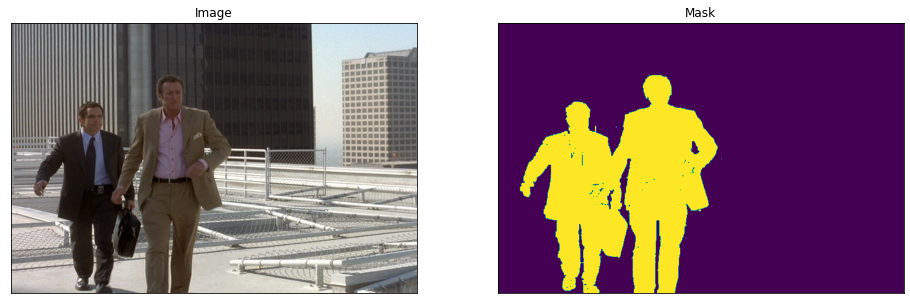

In [419]:
dataset = Dataset(size=2000, classes=['Background'])

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

VOC Dataloader

In [420]:
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", 
    "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", 
    "person", "potted plant", "sheep", "sofa", "train", "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128], 
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], 
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128],
]

In [421]:
class TransformedVOC(VOCSegmentation):
    # def __init__(self, augmentation=None, preprocessing=None, classes=VOC_CLASSES):
    def __init__(self, root, image_set, download=False,  augmentation=None, preprocessing=None):
        super(TransformedVOC, self).__init__(root=root, image_set=image_set, download=download)
        # self.classes = classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.remove_list = []

    # @staticmethod
    # def _convert_to_segmentation_mask(mask, labels):
    #     height, width = mask.shape[:2]
    #     segmentation_mask = np.zeros((height, width, len(labels)), dtype=np.float32)
    #     for idx, label in enumerate(labels):
    #         label_idx = VOC_CLASSES.index(label)
    #         label_color = VOC_COLORMAP[label_idx]
    #         segmentation_mask[:, :, idx] = np.all(mask == label_color, axis=-1).astype(float)
    #     return segmentation_mask

    def __getitem__(self, idx):
        # image = cv2.imread(self.images[idx])
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # mask = cv2.imread(self.masks[idx])
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        # mask = self._convert_to_segmentation_mask(mask, self.classes)

        image, mask = super(TransformedVOC, self).__getitem__(idx)
        image = np.array(image)
        mask = np.array(mask)
        mask = mask.astype('float')
        mask = np.where(mask==15, 1., 0.)
        uniques = np.unique(mask)
        if 1. not in uniques:
            self.remove_list.append(idx)
        mask = mask[:,:,np.newaxis]

         # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

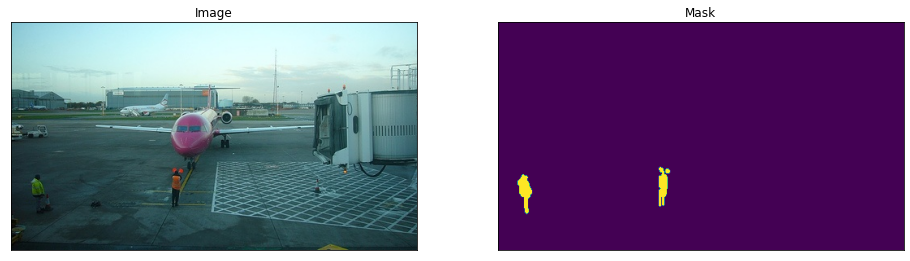

In [422]:
dataset = TransformedVOC(root="data/", image_set="trainval", download=False)

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

VOC Orig Dataloader

In [423]:
class VOCOrig(VOCSegmentation):
    def __init__(self, root, image_set,  augmentation=None, preprocessing=None, classes=VOC_CLASSES):
        super(VOCOrig, self).__init__(root, image_set = image_set)
        self.classes = classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    @staticmethod
    def _convert_to_segmentation_mask(mask, labels):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(labels)), dtype=np.float32)
        for idx, label in enumerate(labels):
            label_idx = VOC_CLASSES.index(label)
            label_color = VOC_COLORMAP[label_idx]
            segmentation_mask[:, :, idx] = np.all(mask == label_color, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask, self.classes)

         # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

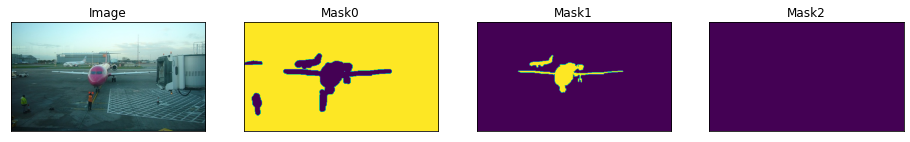

In [424]:
dataset = VOCOrig(root="data/", image_set="trainval")

example_image, example_mask = dataset[0] # get some sample
    
visualize(
    image=example_image, 
    mask0=example_mask[:,:,0],
    mask1=example_mask[:,:,1],
    mask2=example_mask[:,:,2],
)

In [425]:

IMG_SIZE = 128

# Augmentations

 MHP Augmentations

In [426]:
class HeadCrop(object):
    """Crops the given PIL Image around head region."""

    def __init__(self, size, offset):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.offset = offset

    def __call__(self, **kwargs):
        image = kwargs.get('image', None)
        mask = kwargs.get('mask', None)
        combined_file = kwargs.get('combined_file', None)
        

        # Extract head region
        head_masks = [(combined_file == label_index) for label_index in [4, 3, 2, 39]]
        head_mask = reduce(lambda array_a, array_b: array_a | array_b, head_masks)
        # Get coordinates of first head pixel
        first_head = np.where(head_mask == True)
        row, col = first_head[0][0], first_head[1][0]
        x_min = max(0, col - self.size[1] // 2)
        y_min = max(0, row + self.offset - self.size[0] // 2)
        x_max = x_min + self.size[1]
        y_max = y_min + self.size[0]
        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]
        return {"image": cropped_image, "mask": cropped_mask}

    def __repr__(self):
        return self.__class__.__name__ + '()'

class CustomResize(object):
    def __init__(self, size):
        self.size = size
    
    def __call__(self, **kwargs):
        image = kwargs.get('image', None)
        mask = kwargs.get('mask', None)
        image = cv2.resize(image, (self.size, self.size), interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_NEAREST)
        return {"image": image, "mask": mask}


In [427]:
def get_training_augmentation():
    train_transform = [
        HeadCrop((200, 400), 100),
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        HeadCrop((200, 400), 100),
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(test_transform)

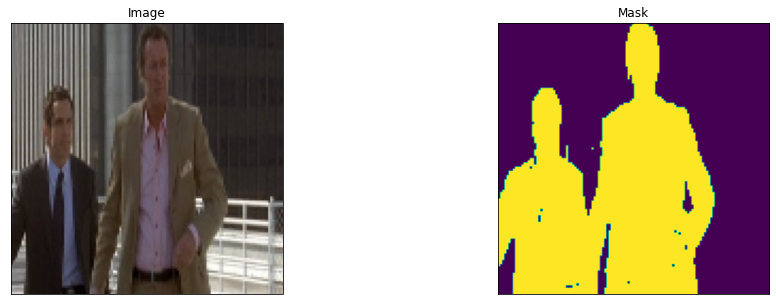

In [428]:
dataset = Dataset(
    augmentation=get_training_augmentation(),
    size=2000, 
    classes=['Background'])

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

VOC Augmentations

In [429]:
def get_training_augmentation_voc():
    train_transform = [
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation_voc():
    test_transform = [
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(test_transform)

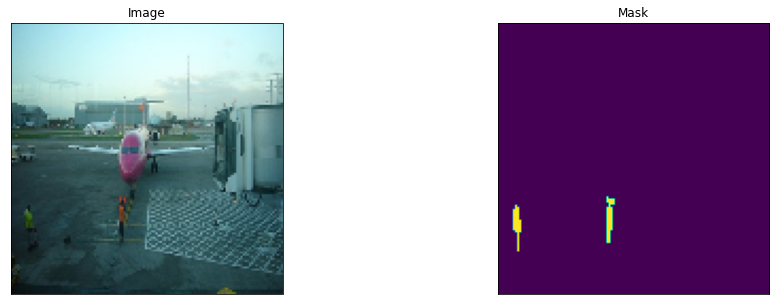

In [430]:
dataset = TransformedVOC(root="data/", image_set="trainval", download=False, augmentation=get_training_augmentation_voc())

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

VOC Orig Augmentations Vis

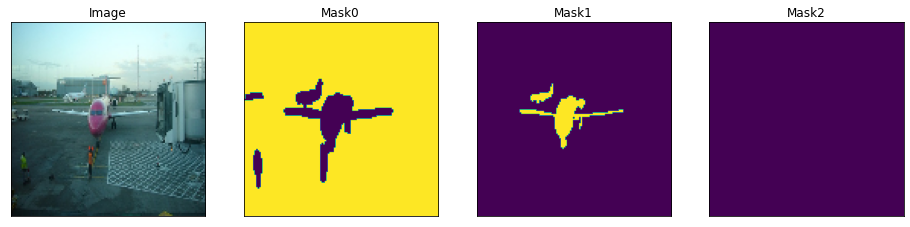

In [431]:
train_dataset_voc_orig = VOCOrig(
    root="data/", 
    image_set="train", 
    augmentation=get_training_augmentation_voc(), 
    )

example_image, example_mask = train_dataset_voc_orig[0] # get some sample

visualize(
    image=example_image, 
    mask0=example_mask[:,:,0],
    mask1=example_mask[:,:,1],
    mask2=example_mask[:,:,2],
)

### VOC Extended Augmentations

In [432]:
def get_training_augmentation_voc_ext():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.RandomCrop(height=200, width=200, always_apply=True),
        albu.Resize(IMG_SIZE,IMG_SIZE),

        albu.augmentations.transforms.GaussNoise(p=0.2),
        albu.augmentations.geometric.transforms.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.augmentations.transforms.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

#### Preprocessing

In [433]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Create models

In [434]:
ENCODER = 'timm-mobilenetv3_small_minimal_100'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['Background']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

models = {}

# create segmentation model with pretrained encoder
models["mhp"] = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

models["mhp"].to(torch.device(DEVICE))

# create segmentation model with pretrained encoder
models["voc"] = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

models["voc"].to(torch.device(DEVICE))

# create segmentation model with pretrained encoder
models["voc_orig"] = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(VOC_CLASSES), 
    activation=ACTIVATION,
)

models["voc_orig"].to(torch.device(DEVICE))

# create segmentation model with pretrained encoder
models["voc_ext"] = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

models["voc_ext"].to(torch.device(DEVICE))



DeepLabV3(
  (encoder): MobileNetV3Encoder(
    (model): MobileNetV3Features(
      (conv_stem): Conv2dSame(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2dSame(16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16, bias=False)
            (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU(inplace=True)
            (se): Identity()
            (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act2): Identity()
          )
        )
        (1): Sequential(
          (0): InvertedResidual(
            (conv_pw): Conv2d(16, 72, kernel_size=(1, 1), 

### Load MHP Dataset

In [435]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

full_dataset = Dataset(
    #size=15403,
    size=3641,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn), 
    classes=CLASSES,
)


full_dataset_size = len(full_dataset)
full_dataset_indices = list(range(full_dataset_size))

# Shuffle
np.random.shuffle(full_dataset_indices)
# Rename for readabilty and limit to 3641
random_indices = full_dataset_indices[0:3641]
random_dataset = torch.utils.data.Subset(full_dataset, random_indices)


# Create train (size=1464), valid (size=1449) and test (size=728) split.
train_valid_dataset, test_dataset = torch.utils.data.random_split(random_dataset, [2913, 728])
train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [1464, 1449])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=NUM_WORKERS)


### Load VOC Dataset

In [436]:
train_dataset_voc = TransformedVOC(
    root="data/", 
    image_set="train", 
    augmentation=get_training_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    )


valid_dataset_voc = TransformedVOC(
    root="data/", 
    image_set="val", 
    augmentation=get_validation_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn))


train_loader_voc = DataLoader(train_dataset_voc, batch_size=16, shuffle=True, num_workers=NUM_WORKERS)
valid_loader_voc = DataLoader(valid_dataset_voc, batch_size=16, shuffle=False, num_workers=NUM_WORKERS)


### Load VOC Orig

In [437]:
train_dataset_voc_orig = VOCOrig(
    root="data/", 
    image_set="train", 
    augmentation=get_training_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn)
    )

valid_dataset_voc_orig = VOCOrig(
    root="data/", 
    image_set="val", 
    augmentation=get_validation_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn)
    )


train_loader_voc_orig = DataLoader(train_dataset_voc_orig, batch_size=16, shuffle=True, num_workers=NUM_WORKERS)
valid_loader_voc_orig = DataLoader(valid_dataset_voc_orig, batch_size=16, shuffle=False, num_workers=NUM_WORKERS)


### Load VOC Extended

In [438]:
file = open('voc_ext_train_idxs.txt', 'r')
idxs = [int(i) for i in file.read().splitlines()]

# Train Dataset
datasets = []
for i in range(0,5):
    dataset = TransformedVOC(root="data/", image_set="train", download=False, augmentation=get_training_augmentation_voc_ext(), preprocessing=get_preprocessing(preprocessing_fn))
    dataset = torch.utils.data.Subset(dataset, idxs)
    datasets.append(dataset)
    

train_dataset_voc_ext_big = torch.utils.data.ConcatDataset(datasets)
train_dataset_voc_ext = torch.utils.data.Subset(train_dataset_voc_ext_big, indices = range(0, 1464))

# Valid Dataset
valid_dataset_voc_ext = TransformedVOC(
    root="data/", 
    image_set="val", 
    augmentation=get_validation_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn)
    )


train_loader_voc_ext = DataLoader(train_dataset_voc_ext, batch_size=16, shuffle=True, num_workers=NUM_WORKERS)
valid_loader_voc_ext = DataLoader(valid_dataset_voc_ext, batch_size=16, shuffle=False, num_workers=NUM_WORKERS)

## Training

### Defining a loss function

In [439]:
class FocalTverskyLoss(torch.nn.Module):
    __name__ = 'focal_tversky_loss'

    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.7, beta=0.3, gamma=0.75):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()  
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
        
        return FocalTversky


In [440]:
# loss = smp.utils.losses.DiceLoss()

ALPHA = 0.7
BETA = 0.3
GAMMA = 0.75

loss1 = FocalTverskyLoss()
loss2 = FocalTverskyLoss()
loss3 = FocalTverskyLoss()
loss4 = FocalTverskyLoss()

metrics1 = [
    smp.utils.metrics.IoU(threshold=0.5),
]
metrics2 = [
    smp.utils.metrics.IoU(threshold=0.5),
]
metrics3 = [
    smp.utils.metrics.IoU(threshold=0.5),
]
metrics4 = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer1 = torch.optim.Adam([ 
    dict(params=models["mhp"].parameters(), lr=0.0001),
])

optimizer2 = torch.optim.Adam([ 
    dict(params=models["voc"].parameters(), lr=0.0001),
])

optimizer3 = torch.optim.Adam([ 
    dict(params=models["voc_orig"].parameters(), lr=0.0001),
])

optimizer4 = torch.optim.Adam([ 
    dict(params=models["voc_ext"].parameters(), lr=0.0001),
])


### Create epoch runners 

In [441]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    models["mhp"], 
    loss=loss1, 
    metrics=metrics1, 
    optimizer=optimizer1,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    models["mhp"], 
    loss=loss1, 
    metrics=metrics1, 
    device=DEVICE,
    verbose=True,
)

train_epoch_voc = smp.utils.train.TrainEpoch(
    models["voc"], 
    loss=loss2, 
    metrics=metrics2, 
    optimizer=optimizer2,
    device=DEVICE,
    verbose=True,
)

valid_epoch_voc = smp.utils.train.ValidEpoch(
    models["voc"], 
    loss=loss2, 
    metrics=metrics2, 
    device=DEVICE,
    verbose=True,
)

train_epoch_voc_orig = smp.utils.train.TrainEpoch(
    models["voc_orig"], 
    loss=loss3, 
    metrics=metrics3, 
    optimizer=optimizer3,
    device=DEVICE,
    verbose=True,
)

valid_epoch_voc_orig = smp.utils.train.ValidEpoch(
    models["voc_orig"], 
    loss=loss3, 
    metrics=metrics3, 
    device=DEVICE,
    verbose=True,
)

train_epoch_voc_ext = smp.utils.train.TrainEpoch(
    models["voc_ext"], 
    loss=loss4, 
    metrics=metrics4, 
    optimizer=optimizer4,
    device=DEVICE,
    verbose=True,
)

valid_epoch_voc_ext = smp.utils.train.ValidEpoch(
    models["voc_ext"], 
    loss=loss4, 
    metrics=metrics4, 
    device=DEVICE,
    verbose=True,
)


In [442]:
def run_epoch(train_epoch, valid_epoch, train_loader, valid_loader, name, max_scores):
    print(name)
    train_logs = train_epoch.run(train_loader)
    writer.add_scalar('{}/Loss/train'.format(name), train_logs["focal_tversky_loss"], i)
    writer.add_scalar('{}/IoU/train'.format(name), train_logs["iou_score"], i)

    valid_logs = valid_epoch.run(valid_loader)
    writer.add_scalar('{}/Loss/valid'.format(name), valid_logs["focal_tversky_loss"], i)
    writer.add_scalar('{}/IoU/valid'.format(name), valid_logs["iou_score"], i)
        
    if max_scores[name] < valid_logs['iou_score']:
        max_scores[name] = valid_logs['iou_score']
        torch.save(models[name], log_dir_name + '/best_model_{}.pth'.format(name))
        print('{} Model saved!'.format(name))

## Run training

In [443]:
max_scores = {
    "mhp": 0,
    "voc": 0,
    "voc_orig": 0,
    "voc_ext": 0
}

# for i in range(0, 40):
#     print('\nEpoch: {}'.format(i))
    
#     run_epoch(train_epoch, valid_epoch, train_loader, valid_loader, "mhp", max_scores)
#     run_epoch(train_epoch_voc, valid_epoch_voc, train_loader_voc, valid_loader_voc, "voc", max_scores)
#     run_epoch(train_epoch_voc_orig, valid_epoch_voc_orig, train_loader_voc_orig, valid_loader_voc_orig, "voc_orig", max_scores)    
#     run_epoch(train_epoch_voc_ext, valid_epoch_voc_ext, train_loader_voc_ext, valid_loader_voc_ext, "voc_ext", max_scores)
    
#     if i == 25:
#         optimizer1.param_groups[0]['lr'] = 1e-5
#         optimizer2.param_groups[0]['lr'] = 1e-5
#         optimizer3.param_groups[0]['lr'] = 1e-5
#         optimizer4.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')
        

## Test best saved model

In [445]:
# load best saved checkpoint
# best_model = torch.load('best_model_mhp.pth', map_location=DEVICE)
# best_model_voc = torch.load('best_model_voc.pth', map_location=DEVICE)
# best_model_voc_orig = torch.load('best_model_voc_orig.pth', map_location=DEVICE)
# best_model_voc_ext = torch.load('best_model_voc_ext.pth', map_location=DEVICE)

In [446]:
# create test dataset
## test_dataset defined "Load MHP Dataset" section

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

In [447]:
class CustomValidEpoch(smp.utils.train.ValidEpoch):
    def __init__(self, model, loss, metrics, device=DEVICE, verbose=True):
         super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            device=device,
        )

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)  
            argmax = torch.argmax(prediction, dim=1)
            prediction = torch.where(argmax==15, 1, 0)
            prediction = prediction[:, np.newaxis, :, :]
            loss = self.loss(prediction, y)
        return loss, prediction

metrics1 = [smp.utils.metrics.Accuracy, smp.utils.metrics.Precision, smp.utils.metrics.Recall, smp.utils.metrics.Fscore, smp.utils.metrics.IoU]

test_epoch = smp.utils.train.ValidEpoch(model=best_model, loss=loss1, metrics=metrics1, device=DEVICE)

test_epoch_voc = smp.utils.train.ValidEpoch(model=best_model_voc, loss=loss2, metrics=metrics1, device=DEVICE)

test_epoch_voc_orig = CustomValidEpoch(model=best_model_voc_orig, loss=loss3, metrics=metrics1, device=DEVICE)

test_epoch_voc_ext = smp.utils.train.ValidEpoch(model=best_model_voc_ext, loss=loss4, metrics1=metrics4, device=DEVICE)

### Run test

In [448]:
def run_test_epoch(epoch, dataloader, name):
    print(name)
    logs = epoch.run(dataloader)

    writer.add_scalar('{}/Loss/test'.format(name), logs["focal_tversky_loss"])
    writer.add_scalar('{}/IoU/test'.format(name), logs["iou_score"])

run_test_epoch(test_epoch, test_dataloader, "mhp")
run_test_epoch(test_epoch_voc, test_dataloader, "voc")
run_test_epoch(test_epoch_voc_orig, test_dataloader, "voc_orig")
run_test_epoch(test_epoch_voc_ext, test_dataloader, "voc_ext")


### Inference Time Measurement
https://deci.ai/resources/blog/measure-inference-time-deep-neural-networks/

In [449]:
def measureInferenceTime(model, dataset):
    model.to(DEVICE)
    repetitions= 100
    total_time = 0
    with torch.no_grad():
        for rep in tqdm(range(repetitions)):
            n = np.random.choice(len(dataset))
            image, _ = dataset[n]
            x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
            start = timer()
            _ = best_model.predict(x_tensor)
            end = timer()
            elapsed_time = (end-start)/1000
            total_time += elapsed_time
    inference_time = total_time/repetitions
    print('Average inference time:', inference_time)
    return inference_time


In [450]:
# # MHP Model 
# time = measureInferenceTime(best_model, test_dataset)
# writer.add_scalar('mhp/time', time)
# # VOC Model
# time = measureInferenceTime(best_model_voc, test_dataset)
# writer.add_scalar('voc/time', time)
# # VOC Orig Model
# time = measureInferenceTime(best_model_voc_orig, test_dataset)
# writer.add_scalar('voc_orig/time', time)
# # VOC Orig Model
# time = measureInferenceTime(best_model_voc_ext, test_dataset)
# writer.add_scalar('voc_ext/time', time)


## Visualize predictions

In [463]:
test_dataset_vis = Dataset(
    size=1000,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    # preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataset = Dataset(
    size=1000,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)



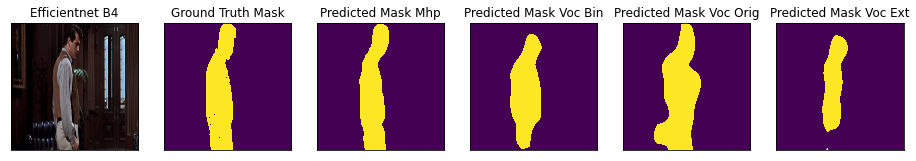

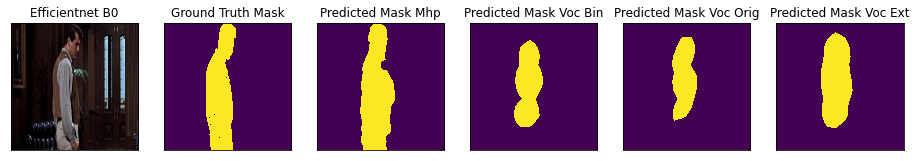

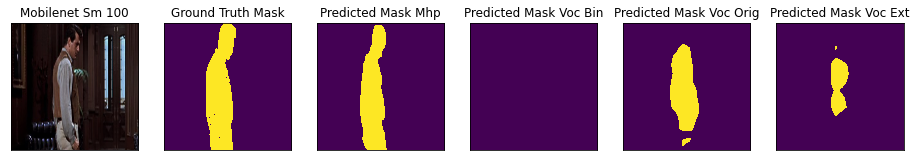

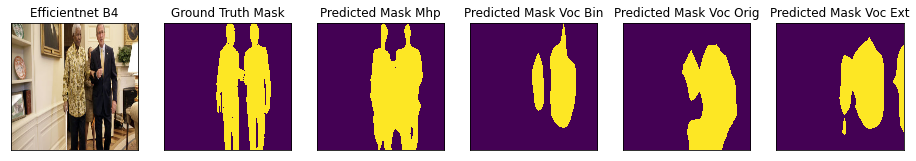

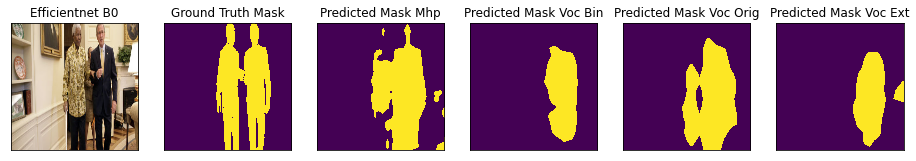

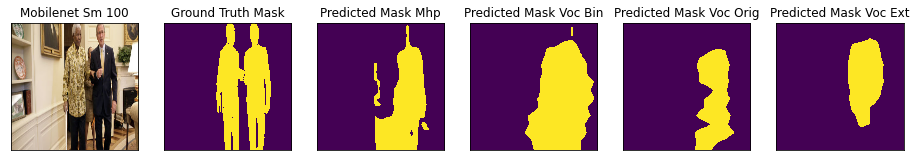

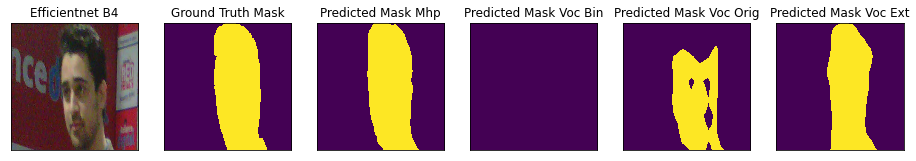

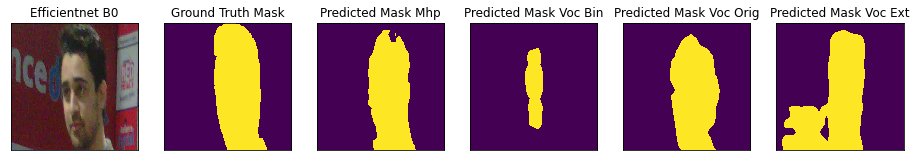

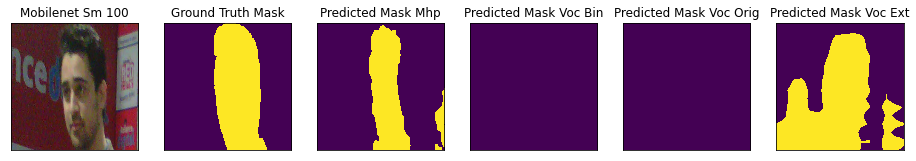

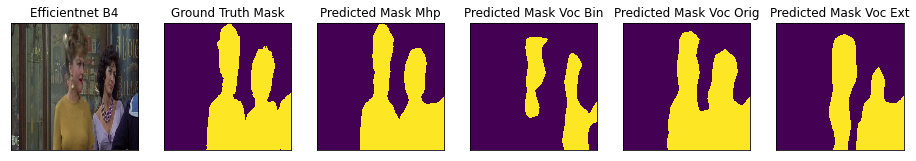

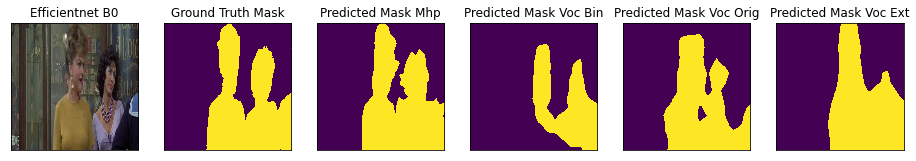

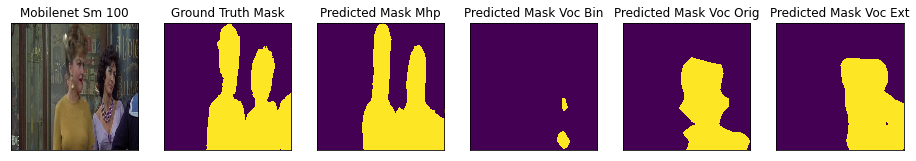

In [473]:

def show_results(model_name, model_1_path, model_2_path, model_3_path, model_4_path):
    
    gt_mask = gt_mask_un.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    
    pr_mask =  torch.load(model_1_path, map_location=DEVICE).predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    pr_mask_voc_orig = torch.load(model_2_path, map_location=DEVICE).predict(x_tensor)
    argmax = torch.argmax(pr_mask_voc_orig, dim=1)
    pr_mask_voc_orig = torch.where(argmax==15, 1, 0)
    pr_mask_voc_orig = pr_mask_voc_orig[:, np.newaxis, :, :]
    pr_mask_voc_orig = (pr_mask_voc_orig.squeeze().cpu().numpy().round())

    pr_mask_voc = torch.load(model_3_path, map_location=DEVICE).predict(x_tensor)
    pr_mask_voc = (pr_mask_voc.squeeze().cpu().numpy().round())

    pr_mask_voc_ext = torch.load(model_4_path, map_location=DEVICE).predict(x_tensor)
    pr_mask_voc_ext = (pr_mask_voc_ext.squeeze().cpu().numpy().round())

    if(model_name == "b4"):
        visualize(
            eﬀicientnet_b4=image_vis, 
            ground_truth_mask=gt_mask, 
            predicted_mask_MHP=pr_mask,
            predicted_mask_VOC_Bin=pr_mask_voc,
            predicted_mask_VOC_Orig=pr_mask_voc_orig,
            predicted_mask_VOC_Ext=pr_mask_voc_ext
        )
    if(model_name == "b0"):
        visualize(
            eﬀicientnet_b0=image_vis, 
            ground_truth_mask=gt_mask, 
            predicted_mask_MHP=pr_mask,
            predicted_mask_VOC_Bin=pr_mask_voc,
            predicted_mask_VOC_Orig=pr_mask_voc_orig,
            predicted_mask_VOC_Ext=pr_mask_voc_ext
        )
    if(model_name == "mb"):
        visualize(
            mobilenet_sm_100=image_vis, 
            ground_truth_mask=gt_mask, 
            predicted_mask_MHP=pr_mask,
            predicted_mask_VOC_Bin=pr_mask_voc,
            predicted_mask_VOC_Orig=pr_mask_voc_orig,
            predicted_mask_VOC_Ext=pr_mask_voc_ext
        )


for i in range(4):
    n = np.random.choice(len(test_dataset))
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask_un = test_dataset[n]
    show_results("b4", "runs/Mar04_00-37-08_noybflqytb/best_model_mhp.pth", "runs/Mar04_00-37-08_noybflqytb/best_model_voc_orig.pth", "runs/Mar04_00-37-08_noybflqytb/best_model_voc.pth", "runs/Mar04_00-37-08_noybflqytb/best_model_voc_ext.pth")
    show_results("b0", "runs/Mar02_12-27-31_nmkv24u1qz/best_model_mhp.pth", "runs/Mar02_12-27-31_nmkv24u1qz/best_model_voc_orig.pth", "runs/Mar02_12-27-31_nmkv24u1qz/best_model_voc.pth", "runs/Mar02_12-27-31_nmkv24u1qz/best_model_voc_ext.pth")
    show_results("mb", "runs/Mar01_21-09-27_n0ybsbnln3/best_model_mhp.pth", "runs/Mar01_21-09-27_n0ybsbnln3/best_model_voc_orig.pth", "runs/Mar01_21-09-27_n0ybsbnln3/best_model_voc.pth", "runs/Mar01_21-09-27_n0ybsbnln3/best_model_voc_ext.pth")